In [12]:
library(dplyr)
library(tidyr)

Warning message:
“package ‘tidyr’ was built under R version 4.2.3”


In [13]:
data = read.table('./5.metacyc/humann2_final_out/humann2_pathabundance_cpm_unstratified2.tsv',check.names = F,header =T,quote="",sep = '\t')

In [14]:
data = data[-c(1,2),]

In [15]:
dim(data)

[1] 336  33

In [16]:
df <- data %>% separate(Pathway	, c('Name1', 'Name2'),sep = '\\: ')

In [17]:
dim(df)

[1] 336  34

In [18]:
df = df[,-1]

In [19]:
rownames(df) = df[,1]

In [20]:
df = df[,-1]

In [21]:
head(df,2)

,KO-CLP1,KO-CLP2,KO-CLP3,KO-CLP4,KO-CLP5,KO-CLP6,KO-CLP7,KO-CLP8,KO-NC1,KO-NC2,⋯,WT-CLP7,WT-CLP8,WT-NC1,WT-NC2,WT-NC3,WT-NC4,WT-NC5,WT-NC6,WT-NC7,WT-NC8
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
folate transformations III (E. coli),373.09400,257.207,311.685,230.93200,246.13900,255.35900,269.87400,203.0820,191.12600,206.99300,⋯,297.997,292.13400,138.053,195.198,234.83600,212.98800,225.29900,282.8620,221.29500,193.82100
superpathway of allantoin degradation in yeast,2.65824,0.000,0.000,5.72585,3.28336,3.07257,6.12238,4.1333,1.28045,1.55677,⋯,0.000,1.71647,0.000,0.000,1.53196,5.17566,6.18274,3.3258,8.44011,7.49206


In [22]:
group = read.table('./5.metacyc/sample.txt',header = T,sep = '\t')

In [23]:
library(tidyverse)
df <- df*100

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.3     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [24]:
df <- df %>% filter(apply(df,1,mean) > 1)

In [25]:
data <- t(df)
data1 <- data.frame(data,group$group)

In [26]:
colnames(data1) <- c(colnames(data),"Group")
data1$Group <- as.factor(data1$Group)

In [27]:
data1$Group

[1] KO-CLP KO-CLP KO-CLP KO-CLP KO-CLP KO-CLP KO-CLP KO-CLP KO-NC  KO-NC 
[11] KO-NC  KO-NC  KO-NC  KO-NC  KO-NC  KO-NC  WT-CLP WT-CLP WT-CLP WT-CLP
[21] WT-CLP WT-CLP WT-CLP WT-CLP WT-NC  WT-NC  WT-NC  WT-NC  WT-NC  WT-NC 
[31] WT-NC  WT-NC 
Levels: KO-CLP KO-NC WT-CLP WT-NC

In [28]:
data1 = data1 %>% filter(Group %in% c('WT-CLP','WT-NC'))

In [29]:
diff <- data1 %>%
    select_if(is.numeric) %>%
    map_df(~ broom::tidy(t.test(. ~ Group,data = data1)), .id = 'var')

In [30]:
diff$p.value <- p.adjust(diff$p.value,"fdr")

In [31]:
diff <- diff %>% filter(p.value < 0.05)

In [32]:
abun.bar <- data1[,c(diff$var,"Group")] %>%
    gather(variable,value,-Group) %>%
    group_by(variable,Group) %>%
    summarise(Mean = mean(value))

`summarise()` has grouped output by 'variable'. You can override using the
`.groups` argument.


In [33]:
diff.mean <- diff[,c("var","estimate","conf.low","conf.high","p.value")]
diff.mean$Group <- c(ifelse(diff.mean$estimate >0,levels(data1$Group)[1],
                            levels(data1$Group)[2]))
diff.mean <- diff.mean[order(diff.mean$estimate,decreasing = TRUE),]

In [34]:
library(ggplot2)
cbbPalette <- c("#E69F00", "#56B4E9")
abun.bar$variable <- factor(abun.bar$variable,levels = rev(diff.mean$var))

In [35]:
p1 <- ggplot(abun.bar,aes(variable,Mean,fill = Group)) +
    scale_x_discrete(limits = levels(diff.mean$var)) +
    coord_flip() +
    xlab("") +
    ylab("Mean proportion (%)") +
    theme(panel.background = element_rect(fill = 'transparent'),
          panel.grid = element_blank(),
          axis.ticks.length = unit(0.4,"lines"),
          axis.ticks = element_line(color='black'),
          axis.line = element_line(colour = "black"),
          axis.title.x=element_text(colour='black', size=12,face = "bold"),
          axis.text=element_text(colour='black',size=10,face = "bold"),
          legend.title=element_blank(),
          legend.text=element_text(size=12,face = "bold",colour = "black",
                                   margin = margin(r = 20)),
          legend.position = c(-1,-0.1),
          legend.direction = "horizontal",
          legend.key.width = unit(0.8,"cm"),
          legend.key.height = unit(0.5,"cm"))
for (i in 1:(nrow(diff.mean) - 1))
    p1 <- p1 + annotate('rect', xmin = i+0.5, xmax = i+1.5, ymin = -Inf, ymax = Inf,
                        fill = ifelse(i %% 2 == 0, 'white', 'gray95'))
 
p1 <- p1 +
    geom_bar(stat = "identity",position = "dodge",width = 0.7,colour = "black") +
    scale_fill_manual(values=cbbPalette)

In [36]:
options(repr.plot.height = 4,repr.plot.width = 12)

In [37]:
abun.bar

variable,Group,Mean
<fct>,<fct>,<dbl>
CMP-pseudaminate biosynthesis,WT-CLP,1040.535
CMP-pseudaminate biosynthesis,WT-NC,4755.361
D-galactose degradation I (Leloir pathway),WT-CLP,10396.165
D-galactose degradation I (Leloir pathway),WT-NC,17736.987
L-arginine biosynthesis I (via L-ornithine),WT-CLP,26190.487
L-arginine biosynthesis I (via L-ornithine),WT-NC,38693.312
L-arginine biosynthesis II (acetyl cycle),WT-CLP,27531.775
L-arginine biosynthesis II (acetyl cycle),WT-NC,40057.600
L-histidine degradation I,WT-CLP,21861.425


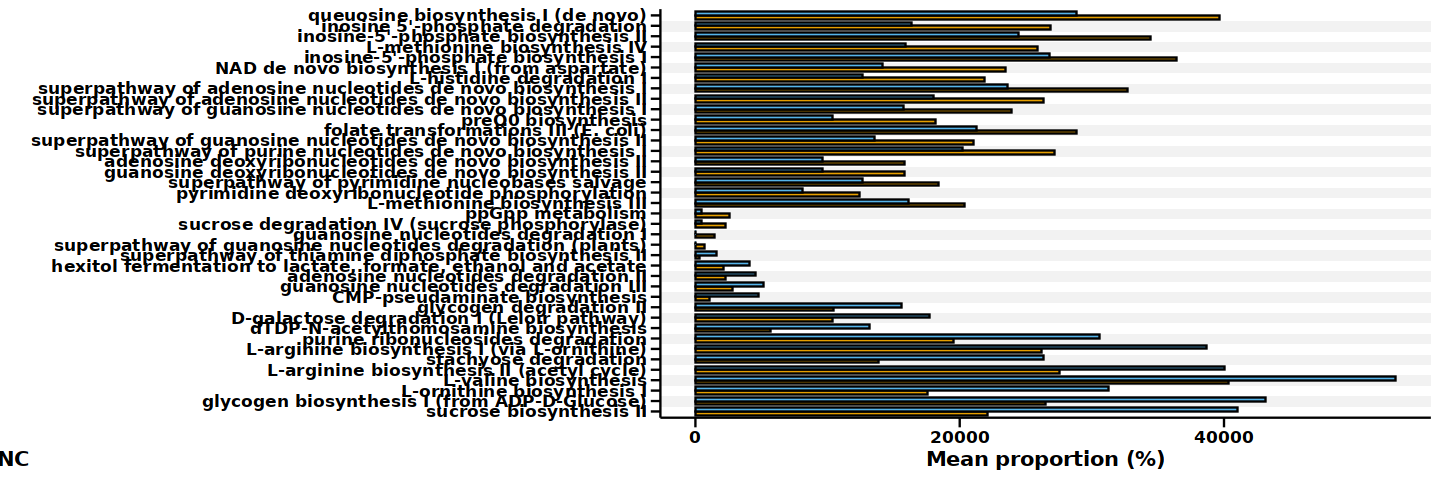

In [38]:
p1

In [39]:
diff.mean$var <- factor(diff.mean$var,levels = levels(abun.bar$variable))
diff.mean$p.value <- signif(diff.mean$p.value,3)
diff.mean$p.value <- as.character(diff.mean$p.value)

In [40]:
p2 <- ggplot(diff.mean,aes(var,estimate,fill = Group)) +
    theme(panel.background = element_rect(fill = 'transparent'),
          panel.grid = element_blank(),
          axis.ticks.length = unit(0.4,"lines"),
          axis.ticks = element_line(color='black'),
          axis.line = element_line(colour = "black"),
          axis.title.x=element_text(colour='black', size=12,face = "bold"),
          axis.text=element_text(colour='black',size=10,face = "bold"),
          axis.text.y = element_blank(),
          legend.position = "none",
          axis.line.y = element_blank(),
          axis.ticks.y = element_blank(),
          plot.title = element_text(size = 15,face = "bold",colour = "black",hjust = 0.5)) +
    scale_x_discrete(limits = levels(diff.mean$var)) +
    coord_flip() +
    xlab("") +
    ylab("Difference in mean proportions (%)") +
    labs(title="95% confidence intervals")
 
for (i in 1:(nrow(diff.mean) - 1))
    p2 <- p2 + annotate('rect', xmin = i+0.5, xmax = i+1.5, ymin = -Inf, ymax = Inf,
                        fill = ifelse(i %% 2 == 0, 'white', 'gray95'))
 
p2 <- p2 +
    geom_errorbar(aes(ymin = conf.low, ymax = conf.high),
                  position = position_dodge(0.8), width = 0.5, size = 0.5) +
    geom_point(shape = 21,size = 3) +
    scale_fill_manual(values=cbbPalette) +
    geom_hline(aes(yintercept = 0), linetype = 'dashed', color = 'black')

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


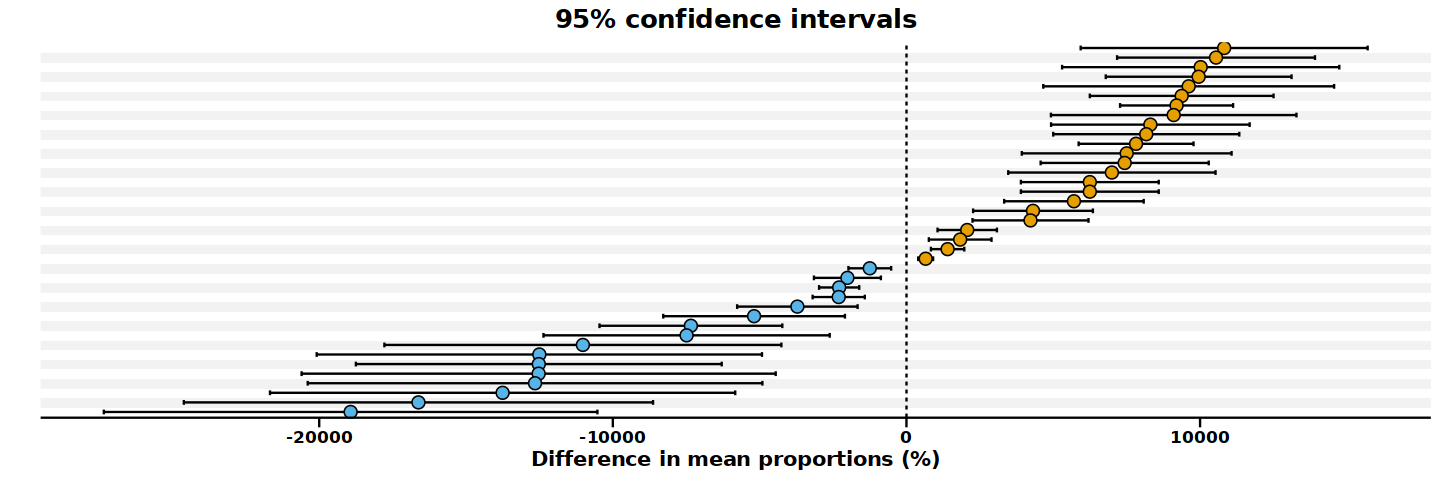

In [41]:
p2

In [42]:
p3 <- ggplot(diff.mean,aes(var,estimate,fill = Group)) +
    geom_text(aes(y = 0,x = var),label = diff.mean$p.value,
              hjust = 0,fontface = "bold",inherit.aes = FALSE,size = 3) +
    geom_text(aes(x = nrow(diff.mean)/2 +0.5,y = 0.85),label = "P-value (corrected)",
             srt = 90,fontface = "bold",size = 5) +
    coord_flip() +
    ylim(c(0,1)) +
    theme(panel.background = element_blank(),
          panel.grid = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          axis.text = element_blank(),
          axis.title = element_blank())

In [43]:
library(patchwork)
p <- p1 + p2 + p3 + plot_layout(widths = c(4,6,2))

Warning message:
“package ‘patchwork’ was built under R version 4.2.3”


In [81]:
options(repr.plot.height = 6,repr.plot.width = 16)

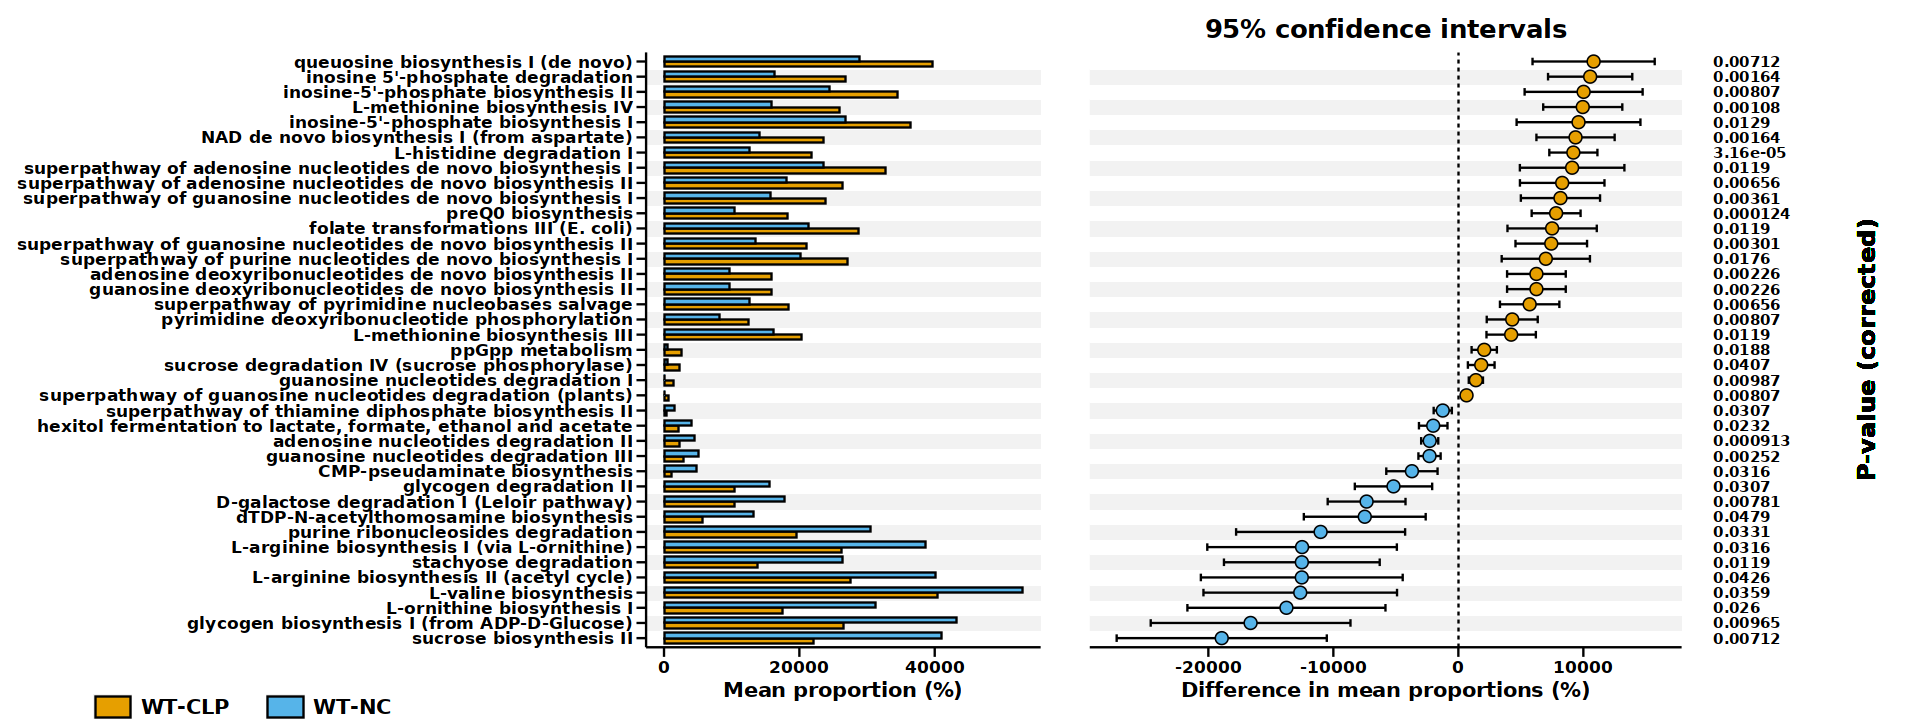

In [87]:
p

In [88]:
outdir = paste(getwd(),"humann_result",sep = "/")
if(dir.exists(outdir)){
  print("dir exists")
}else{
  dir.create(outdir)
}

[1] "dir exists"


In [90]:
ggsave(paste0(outdir,'/',"stampWT-CLPvsWT-NC.pdf"),p,width = 14,height = 6)

In [85]:
write.csv(diff.mean,file = paste0(outdir,'/',"stampWT-CLPvsWT-NC.csv"))

In [98]:
kind = c('g__Akkermansia.s__Akkermansia_muciniphila',
'g__Bacteroides.s__Bacteroides_caecimuris',
'g__Helicobacter.s__Helicobacter_hepaticus',
'g__Acutalibacter.s__Acutalibacter_muris',
'g__Lachnoclostridium.s__Lachnoclostridium_sp. YL32'
)

bad = c('g__Muribaculum.s__Muribaculum_sp. TLL-A4',
'g__Muribaculum.s__Muribaculum_sp. H5',
'g__Muribaculum.s__Muribaculum_intestinale',
'g__Duncaniella.s__Duncaniella_sp. B8',
'g__Lactobacillus.s__Lactobacillus_murinus'
)

In [99]:
humann = read.table("./5.metacyc/humann2_final_out/humann2_pathabundance_cpm_stratified.tsv", header=T, sep="\t")

In [109]:
humann %>% separate(Pathway, c("pathway", "otu"), "[|]") %>% 
filter(otu %in% c(kind,bad)) -> res

Warning message:
“Expected 2 pieces. Additional pieces discarded in 19 rows [355, 356, 357, 358,
359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 408, 409, 438, 439].”


In [110]:
res = res[,c(1,2)]

In [114]:
head(res,2)

,pathway,otu
,<chr>,<chr>
1,UNINTEGRATED,g__Acutalibacter.s__Acutalibacter_muris
2,UNINTEGRATED,g__Akkermansia.s__Akkermansia_muciniphila


In [116]:
csv = merge(res,diff.mean,by.x = 'pathway',by.y = 'var')

In [117]:
write.csv(csv,file = paste0(outdir,'/',"pathway-csv.csv"))